In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'news-summary:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3134949%2F5413244%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240610%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240610T061942Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6537bb345f72640864ab9298599ea2cf25df5dcf53c598d6072661408a98f890a04d347814f4bb015e99af2650a2bd9fc7fba2ce11fed4dc7a5944e8c4cdc6b4ec0f030e1e835c2a6dc4db6fd0b6d09089ee13fd87c50cd4e21416b243542c2c280625c1e023c3a47f15c80aaa1f438dfe9fdaf5705b4c29586eff28eeaf3c428eb4da9e5a5d5b5206c9cca7980dd16fbe3ccf9d52fb69e06f42dbc172e40d4726478c4945da5d1abf23df89fec5a16f7fd76942ce68f5deec52fd1f924b396b355871c6af4fcdce770c3b871173c95aa8e8c5882c80e558d9258a4c349f08bfdaa649ff970924bf3d3fcfa18d4b3461657bd3f1e63ab7d1c0eef7d423922258'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 16394489 bytes downloaded
Downloaded and uncompressed: news-summary
Data source import complete.


# **News Headline Generation**

#### *Paste in a news article and get generated headlines for your story!*

In [4]:
# Connect To Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **1. Exploring, Pre-processing and Transforming Data**

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import time

### 1.1 Exploring Data

In [6]:
df = pd.read_csv("/kaggle/input/news-summary/news_summary_more.csv", encoding='latin-1', usecols=['headlines', 'text'])

In [7]:
df

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,"According to reports, a new version of the 199..."
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [9]:
df.describe()

,headlines,text
count,98401,98401
unique,98280,98360
top,Warne produced 'ball of century' with his 1st ...,Virender Sehwag was captaining India when he h...
freq,3,2


In [10]:
# Check for missing values
print(df.isnull().sum())

headlines    0
text         0
dtype: int64


In [11]:
# Basic statistics
df['article_length'] = df['text'].apply(len)
df['summary_length'] = df['headlines'].apply(len)


print(df[['article_length', 'summary_length']].describe())

       article_length  summary_length
count    98401.000000    98401.000000
mean       357.544161       57.643337
std         24.647988        4.878594
min          4.000000        9.000000
25%        341.000000       56.000000
50%        358.000000       59.000000
75%        376.000000       60.000000
max        513.000000       86.000000


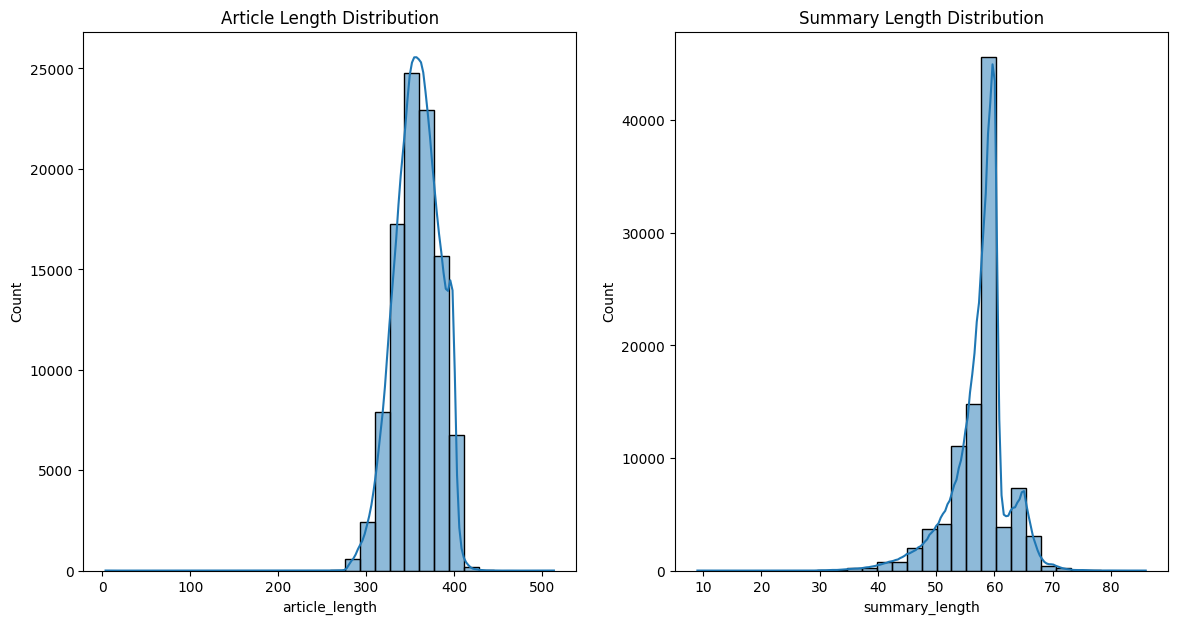

In [12]:
# Visualize the distribution of text lengths
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.histplot(df['article_length'], kde=True, bins=30)
plt.title('Article Length Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df['summary_length'], kde=True, bins=30)
plt.title('Summary Length Distribution')

plt.show()


In [13]:
# Word frequency distribution
def plot_word_frequency(text_data, title):
    all_words = ' '.join(text_data)
    all_words = all_words.split()

    freq_dist = Counter(all_words)
    freq_df = pd.DataFrame(freq_dist.items(), columns=['word', 'count']).sort_values(by='count', ascending=False).head(20)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=freq_df, x='count', y='word')
    plt.title(title)
    plt.show()

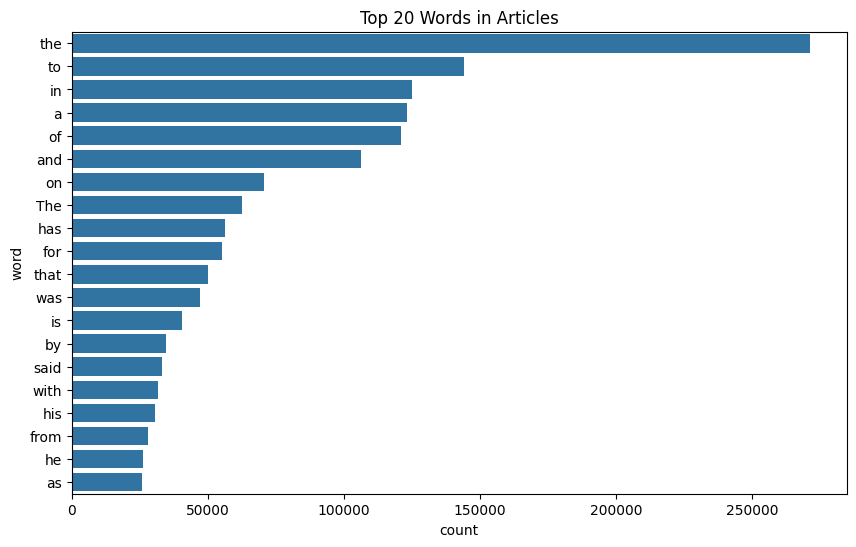

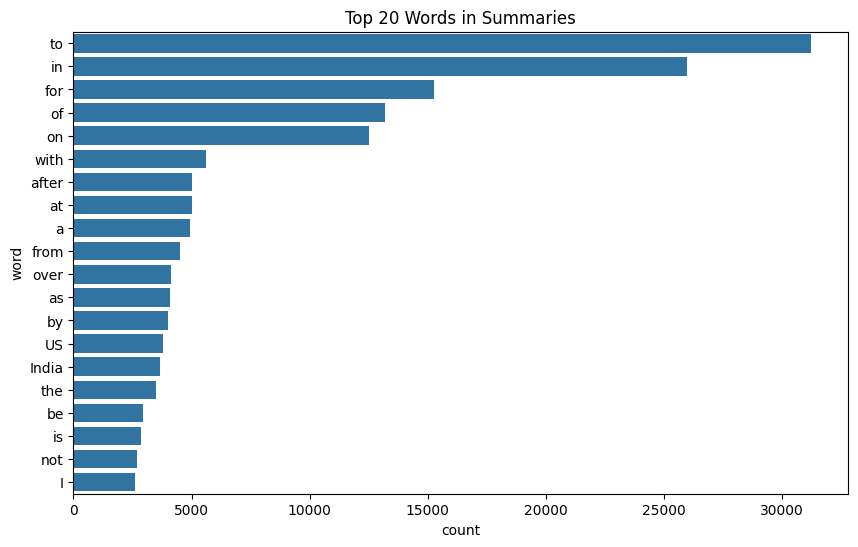

In [14]:
plot_word_frequency(df['text'], 'Top 20 Words in Articles')
plot_word_frequency(df['headlines'], 'Top 20 Words in Summaries')

The larger the word in the visual the more common the word was in the document(s).

In [15]:
# Word clouds
def plot_word_cloud(text_data, title):
    all_words = ' '.join(text_data)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

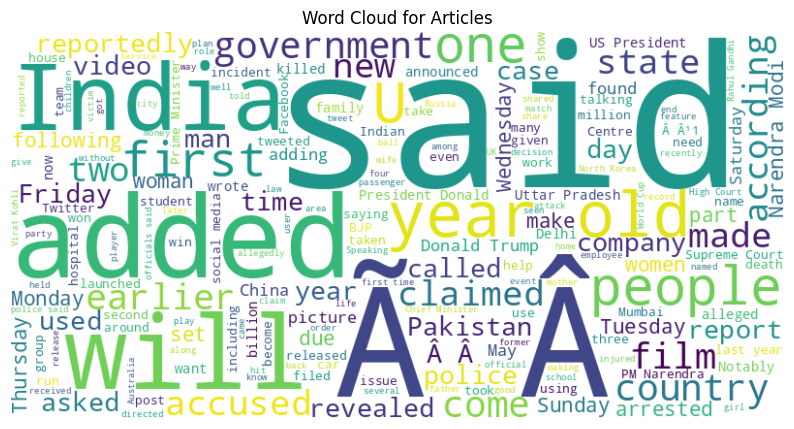

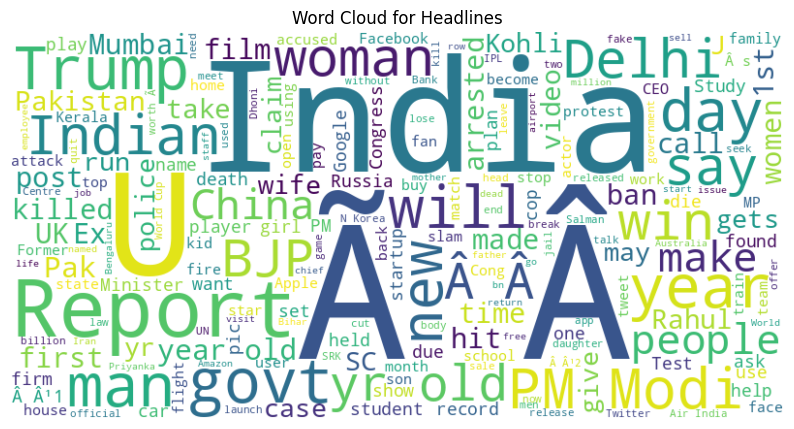

In [16]:
plot_word_cloud(df['text'], 'Word Cloud for Articles')
plot_word_cloud(df['headlines'], 'Word Cloud for Headlines')

### 1.2 Pre-Processing Text

In [17]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

In [18]:
nltk.download('punkt')

nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:
stop_words = set(stopwords.words('english'))

In [20]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

In [21]:
df['cleaned_article'] = df['text'].apply(preprocess_text)

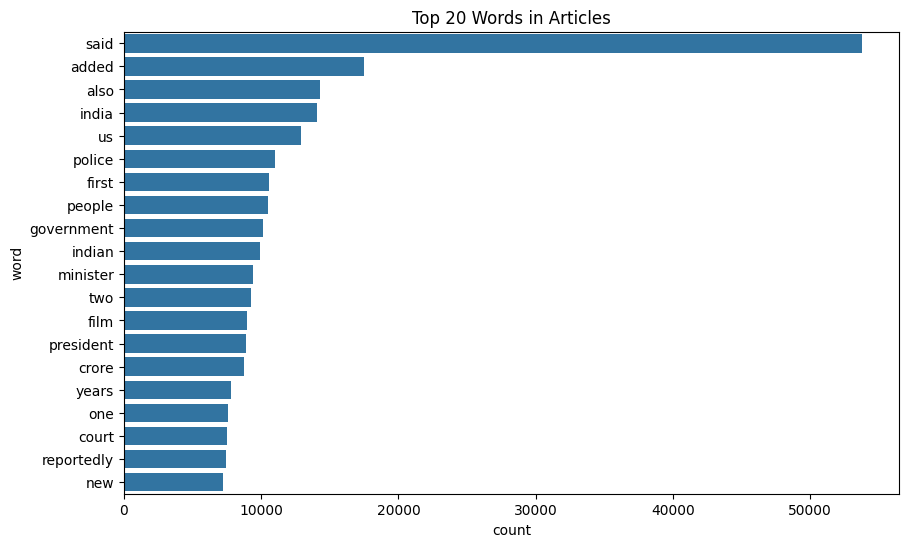

In [22]:
plot_word_frequency(df['cleaned_article'], 'Top 20 Words in Articles')

Lexicon is the total number of words/terms in a language.

While vocabulary is the number of them that are actually in the text corpus

In [23]:
# Vocabulary size
def get_vocabulary_size(text_data):
    all_words = ' '.join(text_data).split()
    return len(set(all_words))

In [24]:
article_vocab_size = get_vocabulary_size(df['cleaned_article'])
summary_vocab_size = get_vocabulary_size(df['headlines'])

print(f'Vocabulary Size for Articles: {article_vocab_size}')
print(f'Vocabulary Size for Summaries: {summary_vocab_size}')

Vocabulary Size for Articles: 120238
Vocabulary Size for Summaries: 75826


### 1.3 Performing Transformations

In [25]:
df.head(5)

,headlines,text,article_length,summary_length,cleaned_article
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",375,65,saurav kant alumnus upgrad iiitbs pg program m...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,347,60,kunal shahs credit card bill payment platform ...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,360,64,new zealand defeated india 8 wickets fourth od...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",346,56,aegon life iterm insurance plan customers enjo...
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,370,67,speaking sexual harassment allegations rajkuma...


In [26]:
df = df.rename(columns={"headlines":"target_text", "cleaned_article":"source_text"})

In [27]:
df.head(5)

,target_text,text,article_length,summary_length,source_text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",375,65,saurav kant alumnus upgrad iiitbs pg program m...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,347,60,kunal shahs credit card bill payment platform ...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,360,64,new zealand defeated india 8 wickets fourth od...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",346,56,aegon life iterm insurance plan customers enjo...
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,370,67,speaking sexual harassment allegations rajkuma...


In [28]:
df_final = df[['source_text', 'target_text']]

In [29]:
df_final.head()

,source_text,target_text
0,saurav kant alumnus upgrad iiitbs pg program m...,upGrad learner switches to career in ML & Al w...
1,kunal shahs credit card bill payment platform ...,Delhi techie wins free food from Swiggy for on...
2,new zealand defeated india 8 wickets fourth od...,New Zealand end Rohit Sharma-led India's 12-ma...
3,aegon life iterm insurance plan customers enjo...,Aegon life iTerm insurance plan helps customer...
4,speaking sexual harassment allegations rajkuma...,"Have known Hirani for yrs, what if MeToo claim..."


Input Format:

"summarize: Your artcicle text"

In [30]:
df_final['source_text'] = "summarize: " + df_final['source_text']
df_final["source_text"]

<ipython-input-30-ac20fd9957c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['source_text'] = "summarize: " + df_final['source_text']


0        summarize: saurav kant alumnus upgrad iiitbs p...
1        summarize: kunal shahs credit card bill paymen...
2        summarize: new zealand defeated india 8 wicket...
3        summarize: aegon life iterm insurance plan cus...
4        summarize: speaking sexual harassment allegati...
                               ...                        
98396    summarize: crpf jawan tuesday axed death sharp...
98397    summarize: uff yeh first song sonakshi sinha s...
98398    summarize: according reports new version 1999 ...
98399    summarize: new music video shows rapper snoop ...
98400    summarize: madhesi morcha alliance seven polit...
Name: source_text, Length: 98401, dtype: object

# **2. Splitting and Training Model**

### 2.1 Paritioning in Training and Testing Set

In [ ]:
train, validate, test = np.split(df_final.sample(frac=1, random_state=42), [int(.6*len(df_final)), int(.8*len(df_final))])

In [ ]:
train

,source_text,target_text
32571,summarize: students karnataka get extra marks ...,K'taka students to get extra marks if parents ...
35184,summarize: syrian antiaircraft defences monday...,Syria shoots down missiles fired at two air bases
59997,summarize: dinosaurlike creatures fossil found...,Dinosaur-like animal's fossil found in Uttarak...
64665,summarize: uttar pradesh government planning f...,"UP may merge Shia, Sunni Waqf boards to preven..."
15343,summarize: egyptian activistactress amal fathy...,Egypt actress gets 2 yrs jail for 'fake news' ...
...,...,...
27666,summarize: scientists using one worlds powerfu...,First-ever image of a planet being born captured
67859,summarize: fire burning underneath us mining t...,A fire has been burning underneath a US town f...
57264,summarize: electronic voting machines evms mal...,Faulty EVMs in Gujarat being replaced immediat...
76248,summarize: kangana ranaut said gets things fig...,I get things only after I fight for them: Kang...


In [ ]:
train.shape, test.shape, validate.shape

((59040, 2), (19681, 2), (19680, 2))

### 2.2 Downloading and Training Model

In [38]:
pip install --upgrade simplet5 -q

In [39]:
!pip install torchinfo -q

In [40]:
from simplet5 import SimpleT5

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


In [41]:
# Instantiating Model Instance
model = SimpleT5()

# Downloaid model from repo
model.from_pretrained(model_type="t5", model_name="t5-base")

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

In [42]:
from torchinfo import summary
import torch

In [43]:
# Using torchinfo to print the summary
summary(model.model, dtypes=[torch.int64])

Layer (type:depth-idx)                                  Param #
T5ForConditionalGeneration                              --
├─Embedding: 1-1                                        24,674,304
├─T5Stack: 1-2                                          24,674,304
│    └─Embedding: 2-1                                   (recursive)
│    └─ModuleList: 2-2                                  --
│    │    └─T5Block: 3-1                                7,079,808
│    │    └─T5Block: 3-2                                7,079,424
│    │    └─T5Block: 3-3                                7,079,424
│    │    └─T5Block: 3-4                                7,079,424
│    │    └─T5Block: 3-5                                7,079,424
│    │    └─T5Block: 3-6                                7,079,424
│    │    └─T5Block: 3-7                                7,079,424
│    │    └─T5Block: 3-8                                7,079,424
│    │    └─T5Block: 3-9                                7,079,424
│    │    └─T5Block: 3

In [44]:
import time

Using limited dataset and token sizes due to hardware limitations

In [ ]:
# Training The Model
total_time = time.time()

model.train(train_df=train[:10000],
            eval_df=validate[:1500],
            source_max_token_len=256,
            target_max_token_len=25,
            batch_size=8, max_epochs=5, use_gpu=True)


total_time = time.time() - total_time

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO:pytorch_lightning.utilities.seed:Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
print(f"Training time: {total_time}")

Training time: 3875.074220895767


### 2.3 Saving Model

In [ ]:
import os
import zipfile

In [ ]:
def zip_folder(folder_path, output_path):
    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), folder_path))

folder_to_zip = '/content/outputs/simplet5-epoch-4-train-loss-0.9674-val-loss-1.6346'
output_zip_path = '/content/outputs/weights.zip'

zip_folder(folder_to_zip, output_zip_path)

# **3. Evaluating Model**

**Optional Code, I am importing it directly after the files have been generated**

In [33]:
import zipfile
import os

def unzip_file(zip_file, extract_dir):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)


In [35]:
# Example usage:
zip_file = '/content/drive/MyDrive/Model Weights/t5-headline-generation.zip'  # Replace 'example.zip' with the name of your zip file
extract_dir = '//content/weights'  # Replace 'extracted' with the directory where you want to extract the files

# Create the extract directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Unzip the file
unzip_file(zip_file, extract_dir)

### 3.1 Testing Model On Example

In [45]:
MODEL_PATH = "/content/weights"

In [46]:
model.load_model("t5", MODEL_PATH, use_gpu=False)

In [47]:
text_to_summarize="""summarize: Twitter’s interim resident grievance officer for India has stepped down, leaving the micro-blogging site without a grievance official as mandated by the new IT rules to address complaints from Indian subscribers, according to a source.

The source said that Dharmendra Chatur, who was recently appointed as interim resident grievance officer for India by Twitter, has quit from the post.

The social media company’s website no longer displays his name, as required under Information Technology (Intermediary Guidelines and Digital Media Ethics Code) Rules 2021.

Twitter declined to comment on the development.

The development comes at a time when the micro-blogging platform has been engaged in a tussle with the Indian government over the new social media rules.

The government has slammed Twitter for deliberate defiance and failure to comply with the country’s new IT rules.
"""

output = model.predict(preprocess_text(text_to_summarize))

In [48]:
output, output[0]

(["Twitter's interim resident grievance officer steps down, source says"],
 "Twitter's interim resident grievance officer steps down, source says")

### 3.2 Performing Predictions

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [ ]:
len(test)

19681

In [ ]:
test_set = test[:100]

In [ ]:
test_set.head()

,source_text,target_text
42974,summarize: many 500 students sat mumbai railwa...,Mumbai rail roko protest for permanent jobs ca...
70072,summarize: former australia batsman dean jones...,Waqar trolls ex-Aussie cricketer over breaking...
41811,summarize: uc berkeley engineers built brightl...,New ultra thin display becomes 'invisible' whe...
51298,summarize: londonbased mental health charity s...,App helps users resist the urge to harm themse...
50333,summarize: seventeenyearold spinner sandeep la...,1st Nepal player to get into IPL has never pla...


In [ ]:
data, labels = test_set["source_text"], test_set["target_text"]

In [ ]:
len(data)

100

In [ ]:
data.values[0], data.values[20]

('summarize: many 500 students sat mumbai railway tracks tuesday morning called rail roko protest railway minister piyush goyal said hold meeting agitating apprentices demanding permanent jobs railways police resorted lathi charge agitators started pelting stones cm devendra fadnavis said',
 'summarize: russias proposal joint investigation poisoning former spy sergei skripal daughter voted organisation prohibition chemical weapons russia lost vote 15 votes six uk alleged nerve agent used poison skripals came russia')

In [ ]:
def get_model_predictions(paragraphs):
  total_predictions = []
  for para in paragraphs:
    # num += 1
    # if num == 10: break

    # print(para)

    paragraph = preprocess_text(para)

    headline = model.predict(paragraph)[0]

    # print(f"Output: {headline}\n")

    total_predictions.append(headline)

  return total_predictions

In [ ]:
predictions_time = time.time()

predictions = get_model_predictions(data.values)

predictions_time = time.time() - predictions_time

In [ ]:
predictions_time

217.61827397346497

In [ ]:
predictions

['500 students call for rail roko protest in Mumbai',
 'Dean Jones retweets video of clean bowled by waqar Younis',
 'Engineers build light emitting device millimetres wide, fully transparent',
 'App helps users resist urge to harm by offering solutions',
 '17-yr-old spinner buys Delhi Daredevils for 120 lakh in IPL',
 "India's 13-match unbeaten run ends in a loss to Kyrgyz Republic",
 'CJI Dipak Misra could be held guilty of misbehaving, says Vice President',
 'Rahul slams PM Modi over fuel price hike post demonetisation',
 'Ram temple issue will be resolved within 24 hrs: UP CM Yogi',
 'Dhoni coach backs Indian to play WC 2019 with immeasurable strength',
 'Chinese vase found in shoebox auctioned for 1128 crore',
 'Retail inflation hits 17-month low of 233 in November',
 'Govt plans to link driving licence with Aadhaar: Prasad',
 '30-second video asks transgender employees for equal treatment',
 "Flybe flight's windscreen cracked after takeoff",
 "Shah Rukh Khan reposts pic of Smriti

### 3.3 Calculating Metrics For Evaluation

- ROUGE (Recall-Oriented Understudy for Gisting Evaluation): ROUGE evaluates the overlap between the generated summary and the reference summaries in terms of n-grams. It's suitable for measuring content preservation and relevance.

\

- BLEU (Bilingual Evaluation Understudy): BLEU measures the precision of the generated summary by comparing it with the reference summaries in terms of n-grams. It's useful for assessing the fluency and relevance of the summary.

\

- METEOR (Metric for Evaluation of Translation with Explicit Ordering): METEOR considers not only exact word matches but also synonyms and paraphrases. It's good for assessing the fluency and relevance of the summary.

In [ ]:
!pip install rouge-score -q

  Preparing metadata (setup.py) ... done


In [ ]:
import nltk
from nltk.translate import bleu_score
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer

In [ ]:
def rouge_score(hypotheses, references):
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge-1': [], 'rouge-2': [], 'rouge-l': []}
    for hyp, ref in zip(hypotheses, references):
        scores = rouge.score(hyp, ref)
        rouge_scores['rouge-1'].append(scores['rouge1'].fmeasure)
        rouge_scores['rouge-2'].append(scores['rouge2'].fmeasure)
        rouge_scores['rouge-l'].append(scores['rougeL'].fmeasure)
    return rouge_scores

In [ ]:
def bleu_score_wrapper(hypotheses, references):
    return bleu_score.corpus_bleu([[ref.split()] for ref in references], [hyp.split() for hyp in hypotheses])

In [ ]:
labels.values[0], labels.values[20]

('Mumbai rail roko protest for permanent jobs called off',
 'Russia fails in bid for joint inquiry into spy poisoning')

In [ ]:
# Example usage:
hypotheses = predictions
references = labels

# Calculate metrics
rouge_scores = rouge_score(hypotheses, references)
bleu_scores = bleu_score_wrapper(hypotheses, references)


print("ROUGE Scores:", rouge_scores)
print("BLEU Score:", bleu_scores)

ROUGE Scores: {'rouge-1': [0.6666666666666666, 0.10526315789473685, 0.0, 0.7368421052631577, 0.08, 0.16, 0.0909090909090909, 0.3157894736842105, 0.380952380952381, 0.5714285714285713, 0.8421052631578948, 0.6666666666666666, 0.823529411764706, 0.09999999999999999, 0.6250000000000001, 0.3636363636363636, 0.34782608695652173, 0.380952380952381, 0.5555555555555556, 0.8571428571428572, 0.380952380952381, 0.6363636363636364, 0.0, 0.28571428571428575, 0.9473684210526316, 0.5, 0.5714285714285713, 0.5454545454545454, 0.5, 0.11764705882352941, 0.4444444444444445, 0.23529411764705882, 1.0, 0.4615384615384615, 0.28571428571428564, 0.5, 0.33333333333333326, 0.48000000000000004, 0.6666666666666665, 0.9, 0.45454545454545453, 0.30769230769230765, 0.4000000000000001, 0.1111111111111111, 0.6666666666666666, 0.41666666666666663, 0.64, 0.9411764705882353, 0.9473684210526316, 0.5217391304347826, 0.4, 0.28571428571428575, 0.4615384615384615, 0.5263157894736842, 0.88, 0.5, 0.7000000000000001, 0.4761904761904

###3 3.4 Plotting Metrics

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_scores(scores, title):
    avg_scores = {metric: sum(values) / len(values) for metric, values in scores.items()}
    plt.figure(figsize=(8, 6))
    plt.bar(avg_scores.keys(), avg_scores.values(), color='skyblue')
    plt.title(title)
    plt.xlabel('Metric')
    plt.ylabel('Average Score')
    plt.show()

In [ ]:
rouge_scores.keys(), rouge_scores.values()

(dict_keys(['rouge-1', 'rouge-2', 'rouge-l']),
 dict_values([[0.6666666666666666, 0.10526315789473685, 0.0, 0.7368421052631577, 0.08, 0.16, 0.0909090909090909, 0.3157894736842105, 0.380952380952381, 0.5714285714285713, 0.8421052631578948, 0.6666666666666666, 0.823529411764706, 0.09999999999999999, 0.6250000000000001, 0.3636363636363636, 0.34782608695652173, 0.380952380952381, 0.5555555555555556, 0.8571428571428572, 0.380952380952381, 0.6363636363636364, 0.0, 0.28571428571428575, 0.9473684210526316, 0.5, 0.5714285714285713, 0.5454545454545454, 0.5, 0.11764705882352941, 0.4444444444444445, 0.23529411764705882, 1.0, 0.4615384615384615, 0.28571428571428564, 0.5, 0.33333333333333326, 0.48000000000000004, 0.6666666666666665, 0.9, 0.45454545454545453, 0.30769230769230765, 0.4000000000000001, 0.1111111111111111, 0.6666666666666666, 0.41666666666666663, 0.64, 0.9411764705882353, 0.9473684210526316, 0.5217391304347826, 0.4, 0.28571428571428575, 0.4615384615384615, 0.5263157894736842, 0.88, 0.5, 

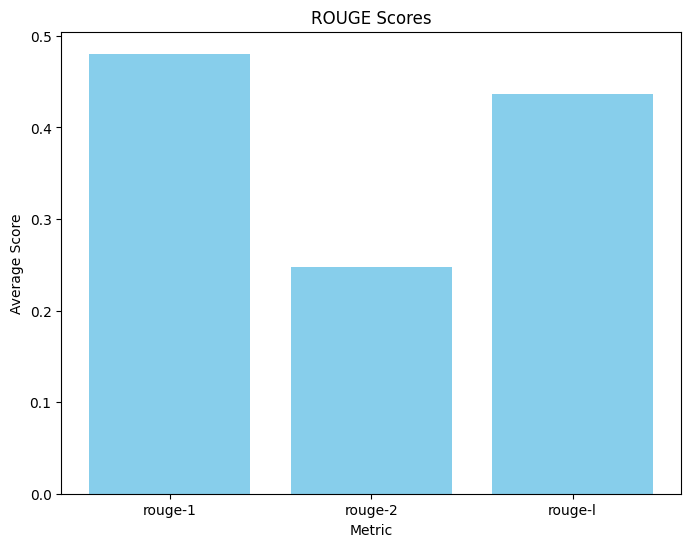

In [ ]:
# Plot scores
plot_scores(rouge_scores, 'ROUGE Scores')
# plot_scores({'METEOR': meteor_scores}, 'METEOR Scores')


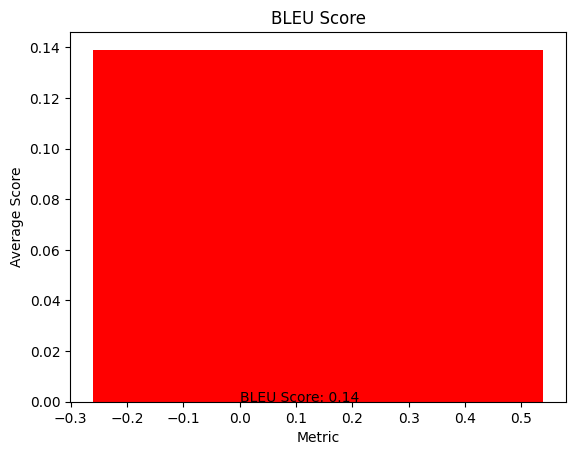

In [ ]:
# Plotting BLUE Score
plt.bar(bleu_scores, bleu_scores, color='red')
plt.title('BLEU Score')
plt.xlabel('Metric')
plt.ylabel('Average Score')
plt.text(0, 0, f'BLEU Score: {bleu_scores:.2f}')
plt.show()

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def meteor_score_wrapper(hypotheses, references):
    tokenized_hypotheses = [nltk.word_tokenize(hyp) for hyp in hypotheses]
    tokenized_references = [nltk.word_tokenize(ref) for ref in references]
    return [meteor_score([ref], hyp) for ref, hyp in zip(tokenized_references, tokenized_hypotheses)]


In [ ]:
meteor_scores = meteor_score_wrapper(hypotheses, references)
print("METEOR Scores:", meteor_scores)

METEOR Scores: [0.5679012345679012, 0.06097560975609756, 0.0, 0.7602601480152501, 0.03937007874015748, 0.09009009009009009, 0.044642857142857144, 0.15, 0.5461165048543689, 0.42216721672167207, 0.8017676767676769, 0.5336896663427275, 0.7740169238427077, 0.04, 0.5068181818181817, 0.33633474576271183, 0.2446705426356589, 0.34090909090909094, 0.48888888888888893, 0.7992187500000002, 0.15, 0.6490885416666666, 0.03246753246753247, 0.2028218694885362, 0.9137614678899082, 0.40917431192660547, 0.3757575757575758, 0.5113636363636364, 0.484, 0.0684931506849315, 0.6299603174603176, 0.1111111111111111, 0.9993141289437586, 0.2127659574468085, 0.15625000000000003, 0.3811965811965813, 0.3537735849056604, 0.3962101636520241, 0.4732510288065843, 0.8880208333333333, 0.20833333333333337, 0.3842940685045948, 0.3381818181818182, 0.09900990099009903, 0.654320987654321, 0.5067567567567567, 0.7211538461538461, 0.7575757575757577, 0.9054545454545455, 0.5514705882352942, 0.2388369678089304, 0.12820512820512822, 

In [ ]:
def plot_scores(scores, title):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(scores)), scores, color='skyblue')
    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Score')
    plt.show()

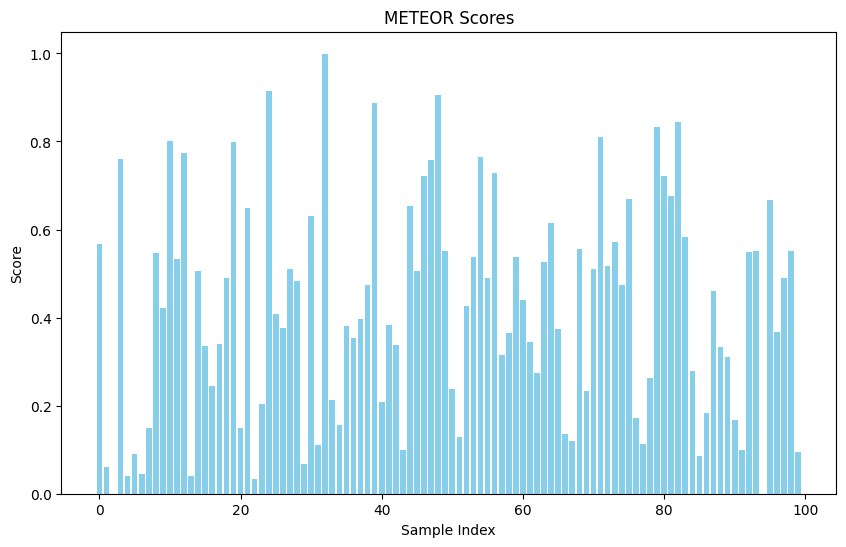

In [ ]:
# Plot METEOR scores
plot_scores(meteor_scores, 'METEOR Scores')

# User Interface in Gradio

In [49]:
!pip install gradio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 10.9 MB/

In [50]:
import gradio as gr

In [51]:
# Define the function to generate headlines
def generate_headline(paragraph):
    paragraph = preprocess_text(paragraph)

    # Use the SimpleT5 model to generate the headline
    headline = model.predict("summarize: " + paragraph)

    return headline[0]

In [52]:
# Create a Gradio interface
input_text = gr.Textbox(lines=7, label="Enter Your Story")
output_text = gr.Textbox(label="Generated Headline")


# Interface title and description
title="News Headline Generation"
description="Submit your news article and get a generated headline for your story!"

In [ ]:
# Launch the Gradio interface
gr.Interface(fn=generate_headline, inputs=input_text, outputs=output_text, title=title, description=description).launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://aa03e9d91ff324c01e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Token indices sequence length is longer than the specified maximum sequence length for this model (828 > 512). Running this sequence through the model will result in indexing errors
